In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoConfig, AutoModelForSequenceClassification
from transformers import CanineForSequenceClassification, CanineTokenizer, BertTokenizer
from torch.utils.data import Dataset
from datasets import load_metric
from sklearn.metrics import roc_auc_score
from scipy.special import softmax
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.utils import resample
import torch.nn as nn

In [2]:
def compute_metrics(eval_pred):
    precision = load_metric("precision")
    recall = load_metric("recall")
    f1 = load_metric("f1")
    acc = load_metric("accuracy")
    mcc = load_metric("matthews_correlation")
    #auc = load_metric("auc")
    
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision = precision.compute(predictions=predictions, average = "macro", references=labels)["precision"]
    recall = recall.compute(predictions=predictions, average = "macro", references=labels)["recall"]
    f1 = f1.compute(predictions=predictions, average = "macro", references=labels)["f1"]
    acc = acc.compute(predictions=predictions, references=labels)["accuracy"]
    mcc = mcc.compute(predictions=predictions, references=labels)["matthews_correlation"]
    auc = roc_auc_score(labels, softmax(logits, axis=1), multi_class='ovo', average='macro')
    return {"precision": precision, "recall": recall, "acc": acc, "mcc": mcc, "f1": f1, "auc":auc}

In [3]:
class MalwareDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [37]:
class RandomTransformerClassifier:
    def __init__(self, trainingset, validationset, testset, num_classes, epochs=10, batch_size=8, model_name='google/canine-s', max_sequence_length=2048):
        self.trainingset = trainingset
        self.validationset = validationset
        self.testset = testset
        self.num_classes = num_classes
        self.model_name = model_name
        if 'google/canine' == model_name.split('-')[0]:
            self.tokenizer = CanineTokenizer.from_pretrained(self.model_name)
        else:
            self.tokenizer = BertTokenizer.from_pretrained(self.model_name)
            
        self.tokenizer.model_max_length = max_sequence_length
        self.base_model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=num_classes)
        self.training_args = TrainingArguments(
        output_dir='./results',          # output directory
        #do_train=True,
        do_eval=True,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        metric_for_best_model='eval_auc',
        greater_is_better=True,
        fp16=True,
        num_train_epochs=epochs,              # total number of training epochs
        per_device_train_batch_size=batch_size,  # batch size per device during training
        per_device_eval_batch_size=batch_size,   # batch size for evaluation
        lr_scheduler_type='cosine',
        warmup_steps=500,                # number of warmup steps for learning rate scheduler
        weight_decay=0.01,               # strength of weight decay
        dataloader_num_workers=8,
        #logging_dir='./logs',            # directory for storing logs
        #logging_steps=10,
    )
        
    def fit(self, n_estimators=2):
        self.validation_preds = []
        self.test_preds = []
        for i in range(n_estimators):
            #bagging_trainset = self.trainingset.sample(frac=1, replace=True)
            bagging_trainset = resample(self.trainingset, replace=True, stratify=self.trainingset['class'])
            train_encodings = self.tokenizer(self.get_list_strs(bagging_trainset.api), padding="max_length", truncation=True, return_tensors="pt")
            val_encodings = self.tokenizer(self.get_list_strs(self.validationset.api), padding="max_length", truncation=True, return_tensors="pt")
            test_encodings = self.tokenizer(self.get_list_strs(self.testset.api), padding="max_length", truncation=True, return_tensors="pt")
            
            trainset = MalwareDataset(train_encodings, bagging_trainset['class'].values)
            valset = MalwareDataset(val_encodings, self.validationset['class'].values)
            testset = MalwareDataset(test_encodings, self.testset['class'].values)
            
            trainer = WeightedLossTrainer(
                model=self.base_model, args=self.training_args, train_dataset=trainset, eval_dataset=valset,
                compute_metrics=compute_metrics
            )
            
            trainer.train()
            
            val_preds = trainer.predict(valset)
            test_preds = trainer.predict(testset)
            self.validation_preds.append(val_preds)
            self.test_preds.append(test_preds)
            del bagging_trainset
            del train_encodings
            del val_encodings
            del test_encodings
            del trainset
            del valset
            del testset
            del trainer
            torch.cuda.empty_cache()
            print(f'{i + 1}. estimator is done....')
    def get_preds(self):
        return self.validation_preds, self.test_preds
    
    def get_metrics(self):
        #np.argmax((softmax(val[0].predictions, axis=1) + softmax(val[1].predictions, axis=1))/2, axis=1)
        val_preds = np.zeros_like(self.validation_preds[0].predictions)
        for val in self.validation_preds:
            val_preds += softmax(val.predictions, axis=1)
        
        val_logits = val_preds / len(self.validation_preds)
        val_preds = np.argmax(val_preds / len(self.validation_preds), axis=1)
        
        test_preds = np.zeros_like(self.test_preds[0].predictions)
        for test in self.test_preds:
            test_preds += softmax(test.predictions, axis=1)
        
        test_logits = test_preds / len(self.test_preds)
        test_preds = np.argmax(test_preds / len(self.test_preds), axis=1)
        precision = load_metric("precision")
        recall = load_metric("recall")
        f1 = load_metric("f1")
        acc = load_metric("accuracy")
        mcc = load_metric("matthews_correlation")
    
        val_precision = precision.compute(predictions=val_preds, average = "macro", references=self.validationset["class"].values)["precision"]
        val_recall = recall.compute(predictions=val_preds, average = "macro", references=self.validationset["class"].values)["recall"]
        val_f1 = f1.compute(predictions=val_preds, average = "macro", references=self.validationset["class"].values)["f1"]
        val_acc = acc.compute(predictions=val_preds, references=self.validationset["class"].values)["accuracy"]
        val_mcc = mcc.compute(predictions=val_preds, references=self.validationset["class"].values)["matthews_correlation"]
        val_auc = roc_auc_score(self.validationset["class"].values, softmax(val_logits, axis=1), multi_class='ovo', average='macro')
        
        test_precision = precision.compute(predictions=test_preds, average = "macro", references=self.testset["class"].values)["precision"]
        test_recall = recall.compute(predictions=test_preds, average = "macro", references=self.testset["class"].values)["recall"]
        test_f1 = f1.compute(predictions=test_preds, average = "macro", references=self.testset["class"].values)["f1"]
        test_acc = acc.compute(predictions=test_preds, references=self.testset["class"].values)["accuracy"]
        test_mcc = mcc.compute(predictions=test_preds, references=self.testset["class"].values)["matthews_correlation"]
        test_auc = roc_auc_score(self.testset["class"].values, softmax(test_logits, axis=1), multi_class='ovo', average='macro')

        return {"val_precision": val_precision, "val_recall": val_recall, "val_acc": val_acc, "val_mcc": val_mcc, "val_f1": val_f1, "val_auc":val_auc}, {"test_precision": test_precision, "test_recall": test_recall, "test_acc": test_acc, "test_mcc": test_mcc, "test_f1": test_f1, "test_auc":test_auc}
        

        
    def get_list_strs(self, df):
        lst_str = []
        for i in range(len(df)):
            str_ = df.values[i]
            lst_str.append(str_)
        return lst_str
    

In [87]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
def get_conf_mat(preds, truth):
    test_preds = np.zeros_like(preds[0].predictions)
    for test in preds:
        test_preds += softmax(test.predictions, axis=1)
    test_logits = test_preds / len(preds)
    test_preds = np.argmax(test_logits, axis=1)
    f1 = f1_score(truth, test_preds, average= "macro")
    return confusion_matrix(truth, test_preds), f1

In [5]:
malware_calls_df = pd.read_csv("../datasets/CatakPreprocessingLast.csv")

In [7]:
malware_calls_df.head()

,api,class
0,ldrloaddll ldrgetprocedureaddress regopenkeyex...,Trojan
1,getsystemtimeasfiletime ntallocatevirtualmemor...,Trojan
2,ldrgetdllhandle ldrgetprocedureaddress getsyst...,Backdoor
3,ldrloaddll ldrgetprocedureaddress regopenkeyex...,Backdoor
4,ldrloaddll ldrgetprocedureaddress wsastartup n...,Trojan


In [8]:
malware_calls_df["class"].value_counts()

Trojan        1001
Backdoor      1001
Downloader    1001
Worms         1001
Virus         1001
Dropper        891
Spyware        832
Adware         379
Name: class, dtype: int64

In [9]:
CAT2IDX = {
    'Downloader': 0,
    'Virus': 1,
    'Trojan': 2,
    'Backdoor': 3,
    'Worms': 4,
    'Dropper': 5,
    'Spyware': 6,
    'Adware': 7
}

IDX2CAT = {
    0:'Downloader',
    1:'Virus',
    2:'Trojan',
    3:'Backdoor',
    4:'Worms',
    5:'Dropper',
    6:'Spyware',
    7:'Adware'
}

In [10]:
malware_calls_df['class'] = malware_calls_df['class'].map(lambda x: CAT2IDX[x])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(malware_calls_df,
test_size=0.2, random_state=75, stratify = malware_calls_df['class'])

In [12]:
X_train.head()

,api,class
4596,ntallocatevirtualmemory ntfreevirtualmemory nt...,6
1472,setunhandledexceptionfilter ntallocatevirtualm...,3
4149,ldrgetdllhandle ldrgetprocedureaddress ntalloc...,0
5052,ldrloaddll ldrgetprocedureaddress seterrormode...,1
1623,ldrloaddll __exception__ ldrgetprocedureaddres...,3


In [13]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=75, stratify = X_train['class'])

In [14]:
X_train.head()

,api,class
5516,ldrgetprocedureaddress ldrgetdllhandle ntalloc...,6
6873,createthread ntallocatevirtualmemory ntfreevir...,1
1162,ldrloaddll ldrgetprocedureaddress getsystemtim...,4
2143,ldrloaddll ldrgetprocedureaddress regopenkeyex...,3
2043,ldrloaddll getsystemtimeasfiletime getsystemin...,0


In [15]:
class_weights = (1 - (malware_calls_df['class'].value_counts().sort_index() / len(malware_calls_df))).values
class_weights = torch.from_numpy(class_weights).float().to("cuda")
class_weights

tensor([0.8592, 0.8592, 0.8592, 0.8592, 0.8592, 0.8746, 0.8829, 0.9467],
       device='cuda:0')

In [16]:
from transformers import Trainer
class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        outputs = model(**inputs)
        logits = outputs.get("logits")
        labels = inputs.get("labels")
        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_func(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [17]:
classifier = RandomTransformerClassifier(X_train, X_val, X_test, num_classes=8, 
                                         epochs=20, batch_size=8, max_sequence_length=512, model_name = "bert-base-cased") 
                                         
                                        

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [18]:
classifier.fit(n_estimators=6)

Using amp fp16 backend
***** Running training *****
  Num examples = 4548
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5700
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct f

Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,Mcc,F1,Auc
1,No log,1.817581,0.396480,0.311326,0.326297,0.233082,0.270609,0.712801
2,1.866700,1.704587,0.398320,0.379574,0.364116,0.293302,0.322106,0.771507
3,1.866700,1.485283,0.502636,0.464300,0.455585,0.375181,0.476685,0.819521
4,1.448700,1.475906,0.540291,0.479651,0.482850,0.406824,0.489853,0.824881
5,1.448700,1.547391,0.516271,0.493795,0.488127,0.410859,0.499502,0.825861
6,1.154400,1.524074,0.534653,0.511796,0.507476,0.434226,0.516907,0.835473
7,1.154400,1.555886,0.561673,0.519999,0.515391,0.441997,0.532658,0.838667
8,0.868300,1.636868,0.586642,0.545296,0.538259,0.469109,0.559292,0.842047
9,0.631400,1.722853,0.575645,0.532900,0.525066,0.453687,0.548459,0.843738
10,0.631400,1.752447,0.558743,0.538642,0.530343,0.459576,0.545695,0.847016


***** Running Evaluation *****
  Num examples = 1137
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/

***** Running Prediction *****
  Num examples = 1422
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1. estimator is done....


Using amp fp16 backend
***** Running training *****
  Num examples = 4548
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5700
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct f

Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,Mcc,F1,Auc
1,No log,1.565960,0.554113,0.550498,0.538259,0.468927,0.549558,0.852974
2,0.774700,1.592093,0.574937,0.556389,0.544415,0.476989,0.560312,0.855469
3,0.774700,1.716228,0.578171,0.541878,0.531223,0.463810,0.547491,0.845885
4,0.677800,1.656808,0.593205,0.566795,0.556728,0.491511,0.573273,0.857260
5,0.677800,1.774636,0.583309,0.551698,0.536500,0.468855,0.560375,0.852049
6,0.520700,1.758414,0.577999,0.570331,0.557608,0.492042,0.569679,0.857623
7,0.520700,1.882705,0.601619,0.573412,0.564644,0.498518,0.584007,0.857980
8,0.401000,2.111753,0.571714,0.567830,0.556728,0.490242,0.567591,0.857913
9,0.291900,2.163830,0.590617,0.554503,0.542656,0.473884,0.568018,0.850889
10,0.291900,2.411059,0.587734,0.549044,0.531223,0.463703,0.558956,0.852646


***** Running Evaluation *****
  Num examples = 1137
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/

***** Running Prediction *****
  Num examples = 1422
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


2. estimator is done....


Using amp fp16 backend
***** Running training *****
  Num examples = 4548
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5700
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct f

Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,Mcc,F1,Auc
1,No log,2.790449,0.585062,0.571125,0.558487,0.492152,0.574907,0.857167
2,0.120800,2.902857,0.549610,0.535923,0.522427,0.450811,0.540651,0.841200
3,0.120800,2.626615,0.563111,0.534332,0.521548,0.452402,0.540681,0.835259
4,0.276000,2.553693,0.553395,0.551773,0.535620,0.466959,0.549503,0.847497
5,0.276000,2.750905,0.567391,0.551938,0.535620,0.466838,0.555642,0.836976
6,0.231900,2.733942,0.573021,0.565304,0.553210,0.486806,0.564384,0.844514
7,0.231900,2.763486,0.590899,0.566460,0.552331,0.486493,0.572610,0.845287
8,0.216200,2.957981,0.578860,0.566351,0.548813,0.482253,0.569124,0.845346
9,0.156100,2.982977,0.571014,0.553237,0.539138,0.469963,0.558642,0.841120
10,0.156100,3.051128,0.589766,0.566411,0.551451,0.485951,0.572243,0.846435


***** Running Evaluation *****
  Num examples = 1137
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/

***** Running Prediction *****
  Num examples = 1422
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


3. estimator is done....


Using amp fp16 backend
***** Running training *****
  Num examples = 4548
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5700
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct f

Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,Mcc,F1,Auc
1,No log,3.054691,0.571158,0.555051,0.540018,0.472332,0.555711,0.851285
2,0.110300,2.933461,0.566922,0.541746,0.524186,0.457824,0.544533,0.832561
3,0.110300,2.566249,0.547072,0.527773,0.510994,0.439320,0.529239,0.836532
4,0.292400,2.452255,0.546229,0.548691,0.533861,0.464476,0.545290,0.847435
5,0.292400,2.776103,0.546072,0.545381,0.529464,0.459069,0.543677,0.840031
6,0.246800,2.806568,0.548581,0.537542,0.521548,0.450176,0.539916,0.843489
7,0.246800,2.739012,0.582579,0.556084,0.541777,0.472910,0.566421,0.845342
8,0.210900,2.937898,0.595833,0.569787,0.555849,0.489348,0.579374,0.846509
9,0.152600,2.994643,0.578807,0.563350,0.548813,0.480793,0.569750,0.840866
10,0.152600,3.109411,0.567559,0.559831,0.546174,0.477837,0.561912,0.844167


***** Running Evaluation *****
  Num examples = 1137
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/

***** Running Prediction *****
  Num examples = 1422
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


4. estimator is done....


Using amp fp16 backend
***** Running training *****
  Num examples = 4548
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5700
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct f

Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,Mcc,F1,Auc
1,No log,3.396204,0.571479,0.563115,0.549692,0.482060,0.564856,0.851372
2,0.085000,3.078943,0.582145,0.562450,0.547933,0.482191,0.565032,0.849711
3,0.085000,2.935814,0.567993,0.560132,0.545295,0.477713,0.561645,0.838361
4,0.213000,3.037960,0.573882,0.569589,0.557608,0.490744,0.570459,0.851145
5,0.213000,3.196742,0.556078,0.554189,0.539138,0.471859,0.550718,0.842402
6,0.176400,3.210226,0.561645,0.546556,0.531223,0.460436,0.551777,0.834937
7,0.176400,3.239395,0.597064,0.552876,0.539138,0.473768,0.563416,0.833547
8,0.153300,3.305548,0.590382,0.572681,0.562885,0.496875,0.579533,0.841692
9,0.112200,3.400943,0.573695,0.557164,0.547054,0.479946,0.559705,0.844712
10,0.112200,3.359271,0.582878,0.572235,0.558487,0.493161,0.573878,0.849244


***** Running Evaluation *****
  Num examples = 1137
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/

***** Running Prediction *****
  Num examples = 1422
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


5. estimator is done....


Using amp fp16 backend
***** Running training *****
  Num examples = 4548
  Num Epochs = 20
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 5700
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct f

Epoch,Training Loss,Validation Loss,Precision,Recall,Acc,Mcc,F1,Auc
1,No log,3.421664,0.575054,0.563776,0.551451,0.484192,0.567289,0.848454
2,0.073200,3.629212,0.590484,0.562801,0.547054,0.480947,0.570472,0.838870
3,0.073200,3.267425,0.564764,0.548883,0.536500,0.466786,0.554031,0.835879
4,0.187700,3.140529,0.573739,0.545767,0.533861,0.465401,0.552374,0.834395
5,0.187700,3.497629,0.568706,0.555470,0.542656,0.475204,0.556616,0.835760
6,0.159700,3.364397,0.555951,0.559579,0.545295,0.477843,0.554941,0.838744
7,0.159700,3.322471,0.580960,0.568990,0.552331,0.488113,0.568303,0.838803
8,0.136600,3.294939,0.588839,0.580794,0.569921,0.505240,0.583197,0.845899
9,0.100900,3.484950,0.585515,0.565703,0.555849,0.488711,0.573432,0.848655
10,0.100900,3.560116,0.555719,0.548484,0.535620,0.466133,0.550054,0.839488


***** Running Evaluation *****
  Num examples = 1137
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/

***** Running Prediction *****
  Num examples = 1422
  Batch size = 16
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/nova/anaconda3/envs/maltransform/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


6. estimator is done....


In [19]:
val, test = classifier.get_metrics()

In [20]:
val

{'val_precision': 0.5958372215055354,
 'val_recall': 0.5835428706593234,
 'val_acc': 0.5708003518029904,
 'val_mcc': 0.5059835137353045,
 'val_f1': 0.5881248590124522,
 'val_auc': 0.8653653731935743}

In [21]:
test

{'test_precision': 0.6197419653961398,
 'test_recall': 0.6117272975871431,
 'test_acc': 0.60056258790436,
 'test_mcc': 0.5401585635041992,
 'test_f1': 0.6148856713253446,
 'test_auc': 0.8818358633538768}

In [88]:
cm, f1 = get_conf_mat(classifier.get_preds()[1], X_test["class"])

In [89]:
cm

array([[147,   4,  17,   5,  14,   9,   3,   2],
       [  0, 166,  12,   6,   4,   7,   4,   1],
       [ 15,   2,  80,  27,  24,  21,  30,   1],
       [ 10,   3,  17, 112,  17,  17,  24,   0],
       [ 10,  11,  15,  30, 110,   5,  18,   1],
       [  9,   8,  15,  16,   7, 105,  18,   0],
       [  9,   3,  13,  29,  19,  17,  74,   3],
       [  4,   2,   6,   1,   0,   2,   1,  60]])

In [90]:
f1

0.6148856713253446

In [92]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          f1 = None,
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}; f1 = {:0.4f}'.format(accuracy, misclass,f1))
    plt.show()

In [93]:
target_names = ["Downloader","Virus","Trojan","Backdoor","Worm","Dropper","Spyware","Adware"]

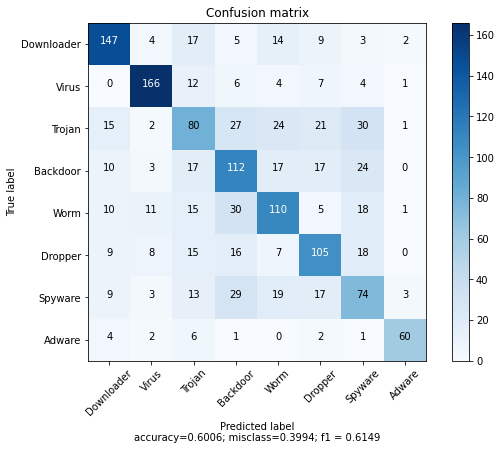

In [94]:
plot_confusion_matrix(cm,
                      target_names,
                      title='Confusion matrix',
                      f1 = f1,
                      cmap=None,
                      normalize=False)